# CMTech Assignment 3: Data Analysis
# Analyzing Amazon Fine Food Reviews

Carolina Peisch (cgp48), Eric Chien (jc3267)

# Abstract

We wanted to examine several key Connective Media theories in our analysis of the Amazon Fine Foods dataset. Firstly, we examined the interplay of "real" and "fake" names among reviewers and analyzed whether the presence of a fake or real name had an effect on the helpfulness score or vote count of a review. Secondly, we thought about Amazon as a community, and picked out a key characteristic which renders it an interactice online forum. Thirdly, we explored the distribution of number of votes over reviews, and also across the entire time span recorded by this dataset. As we found more interesting associations between elements, we decided to conduct correlation analysis, first on the whole dataset, then in an aggregate manner. Finally, we performed sentiment analysis on the reviews to find out whether the sentiment of the text would affect the number of helpful votes it gets.

# Dataset Description

We chose the Amazon Fine Foods Reviews dataset, as found at Kaggle (https://www.kaggle.com/snap/amazon-fine-food-reviews). This dataset is a collection of reviews spanning more than 10 years and includes ~500,000 reviews. 
Some of the key dataset variables that we examined are:
UserId - unique identifier for the user - some users leave reviews across items, some only appear once;
ProfileName - real or fake?;
HelpfulnessNumerator - number of users who found the review helpful;
HelpfulnessDenominator - number of users who indicated whether they found the review helpful.

It is important to note that we established "Total Number of Votes" to indicate how many times a review was voted as either unhelpful or helpful. We also established "Helpfulness Score" to indicate how helpful a review was, therefore the number of helpful votes / number of total votes.

In [40]:
import math
import pickle
import datetime
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [41]:
df = pd.read_csv("Reviews.csv")

In [6]:
df.head(20)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [42]:
print "Number of total unique product:", pd.Series.unique(df["ProductId"]).shape[0]
print "Number of total unique users:", pd.Series.unique(df["UserId"]).shape[0]
# Number of total unique product: 74258
# Number of total unique users: 256059

Number of total unique product: 74258
Number of total unique users: 256059


# Renamed two columns: 'HelpfulnessNumerator', 'HelpfulnessDenominator'

We rename 'HelpfulnessNumerator' to 'NumberOfHelpfulVotes', 
          'HelpfulnessDenominator' to 'TotalNumberOfVotes' to make them easier to understand.

In [43]:
df.rename(columns={'HelpfulnessNumerator':'NumberOfHelpfulVotes'}, inplace=True)
df.rename(columns={'HelpfulnessDenominator':'TotalNumberOfVotes'}, inplace=True)

# Converted timestamp from Unix epoch to readable time

The original time data came in Unix epoch format. In order to make comparisons, we converted the format of the time to a human readable format. Furthermore, we converted each time data to a float(64) value, with the year-value being the integer section of the floating-point number, the month, date and hour as the decimal portion of the floating-point number.

In [44]:
df['Time'] = [float(datetime.datetime.fromtimestamp(timeStamp).strftime('%Y%m%d.%H%M%S')) / 10000 
              for timeStamp in df['Time']]

In [45]:
df.head(20)

,Id,ProductId,UserId,ProfileName,NumberOfHelpfulVotes,TotalNumberOfVotes,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011.042620,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012.090620,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008.081720,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011.061220,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012.102020,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,2012.071120,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,2012.061920,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,2012.050220,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,2011.112219,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,2012.102520,Healthy Dog Food,This is a very healthy dog food. Good for thei...


# Dropped duplicated rows

We identified rows containing identical review text, keeping the first instance of the identical reviews and dropping the additional duplicates.

In [46]:
df = df.drop_duplicates(subset=['Text'], keep='first')

In [47]:
df.shape

(393579, 10)

In [48]:
# After removing duplicates
print "Total number of unique products :", pd.Series.unique(df["ProductId"]).shape[0]
print "Total number of unique users:", pd.Series.unique(df["UserId"]).shape[0]
# Total number of unique products: 67554
# Total number of unique users: 256044

Total number of unique products : 67554
Total number of unique users: 256044


# Added three columns: 'WordsInSummary', 'WordsInText', 'HelpfulnessScore'

Added three columns to record the number of words in title of reviews, number of words in the content of reviews, and the helpfulness score of each review. The helpfulness of a review is represented by the percentage of helpful votes within total number of votes

In [49]:
df["WordsInSummary"] = df["Summary"].apply(lambda k: len(str(k).split()))
df["WordsInText"] = df["Text"].apply(lambda p: len(str(p).split()))
df['HelpfulnessScore'] = (df['NumberOfHelpfulVotes'] / df['TotalNumberOfVotes']) * 100

In [51]:
df.columns

Index([u'Id', u'ProductId', u'UserId', u'ProfileName', u'NumberOfHelpfulVotes',
       u'TotalNumberOfVotes', u'Score', u'Time', u'Summary', u'Text',
       u'WordsInSummary', u'WordsInText', u'HelpfulnessScore'],
      dtype='object')

In [52]:
df.shape

(393579, 13)

# Distribution of number of votes over reviews

In week 10's paper "Meerkat and Periscope: I Stream, You Stream, Apps Stream for Live Streams", we read about the Zipf's law distribution, which is typical of many large-scale community contribution systems. Siersdorfer, Stefan, et al. analyzed the commenting behavior online in their work, "How useful are your comments?: analyzing and predicting youtube comments and comment ratings." In YouTube's case, about 1% of videos got more than ten comments. We would like to see if the votes Amazon users give follow the same kind of distribution.

We first sorted all reviews based on the number of votes they get, and then plotted them out in a scattergram.

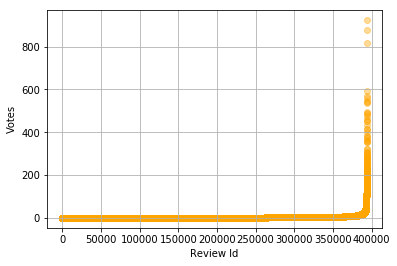

In [445]:
votes_over_reviews = df.sort_values(['TotalNumberOfVotes'], ascending=True)
votes_over_reviews['index'] = [i for i in range(votes_over_reviews.shape[0])]
plt.scatter(x=votes_over_reviews[['index']], y=votes_over_reviews[['TotalNumberOfVotes']], c='Orange', alpha=0.4)

plt.xlabel('Review Id')
plt.ylabel('Votes')
plt.grid(True)
plt.show() = df.sort_values(['TotalNumberOfVotes'], ascending=True)
votes_over_reviews['index'] = [i for i in range(votes_over_reviews.shape[0])]
plt.scatter(x=votes_over_reviews[['index']], y=votes_over_reviews[['TotalNumberOfVotes']], c='Orange', alpha=0.4)

plt.xlabel('Review Id')
plt.ylabel('Votes')
plt.grid(True)
plt.show()

Truly, the distribution of the votes over reviews do follow Zipf's law. As we can see around 12500 reviews out of a total of 393579 (3.17%) have significantly more votes compared to the rest of the reviews.

# Distribution of number of votes over the entire timespan

Out of curiosity, we wanted to see how the number of votes distribute over time regardless of the product grouping. We found that if we excluded some outliers in 2006 and 2009, and considered the fact that the reviews are recorded until 10/25/2012, the distribution of reviews with a certain number of votes is very similar every year.

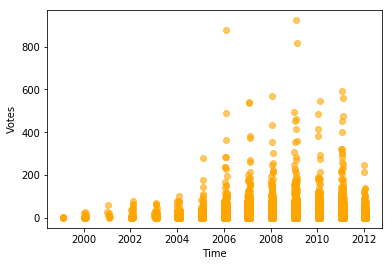

In [396]:
plt.scatter(x=df[['Time']], y=df[['TotalNumberOfVotes']], c='Orange', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Votes')
plt.show()

# Correlation Table (All Columns)

Now that we realized the underlying relationship between the lenght of review and the helpfulness score, we would like to conduct a correlation analysis on the entire data to see if there are any existing patterns that we have not observed.

Initially, we selected 'NumberOfHelpfulVotes', 'TotalNumberOfVotes', 'Score', 'Time', 'WordsInSummary', 'WordsInText' among all the columns to do correlation analysis, yet soon we found out that it would not be logical to include the 'Time' data within the correlation analysis. We will explain the reasons in the next section. So far, we are able to find very strong correlation between number of helpful votes and total votes, as well as a mild correlation between the length of review title and review text.

In [103]:
df.columns

Index([u'Id', u'ProductId', u'UserId', u'HelpfulnessNumerator',
       u'HelpfulnessDenominator', u'Score', u'Time', u'Summary', u'Text',
       u'WordsInText', u'WordsInSummary'],
      dtype='object')

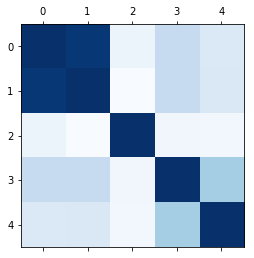

In [116]:
tmp = df[['NumberOfHelpfulVotes', 'TotalNumberOfVotes', 'Score', 'WordsInSummary', 'WordsInText']]
plt.matshow(tmp.corr(), cmap=plt.cm.Blues)
plt.show()

# Only correlation between 'NumberOfHelpfulVotes', 'TotalNumberOfVotes' observed

# Aggregate Correlation Analysis - Attempting to prove the Anchoring Effect

The first question we asked when incorporating the 'Time' column in the overall correlation analysis was, why is our hypothesis? Is there something we would like to prove, or a correlation we assume might exist?

We thought Anchoring Effect might be present in the reviews. In other words, we hope we can prove that the readers tend to rely too heavily on the first piece of review they are offered when making decisions. Since we do not have ground truth data of whether a user bought the product after reading the reviews, we decided to represent the Anchoring Effect with how helpful the user think a review is and whether reviews published earlier receive more helpful votes than reviews published later.

Since two products can be released at two different dates, the last review of a product released in the beginning of the year would have been presumed to be more helpful compared with the first review of a product released near the end of the year. However, it would only be logical if reviews are grouped by the products they belong to, and each review-product category is independent of each other. This is why we cannot simply conduct the correlation analysis directly with 'Time' data without grouping them by their product id.

To carry on with this correlation analysis between groups, we first looked at how many unique products there are in the dataset.

In [53]:
set_productId = set(pd.Series.unique(df["ProductId"]))
set_userId = set(pd.Series.unique(df["UserId"]))
print len(set_productId)
print len(set_userId)

67554
256044


# Created a dictionary to store the data frame for each product

After a few attempts, we decided to store the review data in the format of data frame for each product, and to retain the review-product relationship by keeping the data in a dictionary. We assigned each ProductId to be keys, whose value is a data frame consisting of all the rows with the product id. The operation turned out to require more than two hours, so we set up an AWS 2x-large instance to help us run the task and store the dictionary object as a pickle file, and then we downloaded the pickle file from the instance after it is finished. The dictionary object is then loaded after the pickle was downloaded from the instance.

In [ ]:
reviews_groupby_productId = collections.defaultdict(pd.core.frame.DataFrame)

for i, product in enumerate(set_productId):
    reviews_groupby_productId[product] = df.loc[df['ProductId'] == str(product)]
    if i % 100 == 0:
        print i, 'products recorded in dictionary'

with open('reviews_dict.pickle', 'wb') as file:
    pickle.dump(reviews_groupby_productId, file)

In [268]:
# Verify
print len(reviews_groupby_productId.keys()), 'products'
print sum(len(i) for i in reviews_groupby_productId.values()), 'reviews'

67554 products
393579 reviews


# Weighted Average of Correlation Matrices

We think calculating a weighted average of correlation matrices is a good way to accurately represent aggregate trends. After the dictionary is created on the AWS instance, we downloaded the pickle file and loaded it into the Python Notebook to continue with the task. 

First, we created an empty matrix of our desired size, then we iterated over the entire dictionary. For each unique product, we generated a correlation matrix with these six columns: 'NumberOfHelpfulVotes', 'HelpfulnessDenominator', 'Score', 'Time', 'WordsInSummary', 'WordsInText'. We wanted to obtain a weighted average of all correlation matrix, therefore we continued to sum the product of (number of reviews of this product) * (correlation matrix), and had it divided by the total number of reviews in the end.

In [ ]:
with open('reviews_dict.pickle', 'rb') as file:
    reviews_groupby_productId = pickle.load(file)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

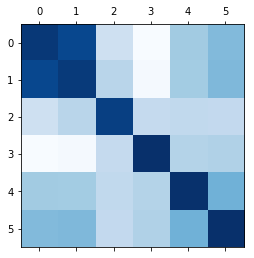

In [217]:
corr_matrix = reviews_groupby_productId[reviews_groupby_productId.keys()[0]][['NumberOfHelpfulVotes', 
                                                                              'TotalNumberOfVotes', 'Score', 
                                                                              'WordsInSummary', 'WordsInText'
                                                                             ]].corr() * 0.0

i = 0
total_reviews = 0

for product, dataframe in reviews_groupby_productId.iteritems():
    i += 1
    tmp = dataframe[['NumberOfHelpfulVotes', 'HelpfulnessDenominator', 'Score', 'Time', 'WordsInSummary', 
                     'WordsInText']]
    if i % 100 == 0:
        print i
    total_reviews += dataframe.shape[0]
    mat = (tmp.corr() * dataframe.shape[0])
    corr_matrix = corr_matrix.add(tmp.corr() * dataframe.shape[0], fill_value=0)

print total_reviews
corr_matrix = corr_matrix / total_reviews
print corr_matrix
plt.matshow(corr_matrix, cmap=plt.cm.Blues)
plt.show()

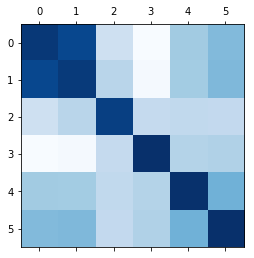

In [224]:
plt.matshow(corr_matrix, cmap=plt.cm.Blues)
plt.show()

To our surprisement, we learned that time had the least correlation with anything else. Helpful votes and the total number of votes still remain high correlated. We also observed mild correlation between long-review-title/long review-text and the number of helpful votes and total votes. Lastly, the correlation between length of review title and length of review text. 

Yes indeed, this experiment is flawed due to the following reasons:
1. Amazon does not display reiews in chronological order, instead rank them by helpfulness from high to low.
2. We do not know which reviews a user has view, nor do we have the ground truth data of whether a user bought the product after reading its reviews.

What we have learned from the results is that Correlation != Causality. It is not logical to assume a user behavior simply because we have proved a correlation. Correlation is a supporting factor, yet can never represent the entire context. 

# Correlation between helpfulness score, and the sentiment of review title and text

We wanted to know whether the sentiment of the review title and the review content has any influence on how likely they are ranked helpful. To achieve so, we utilized the Sentiment Intensity Analyzer in the NLTK package to calculate a compound polarity score for the title and text of each review. A compound score is a overall score ranging between 1 and -1 that indicates whether the given text is of positive or negative sentiment, with 1 being positive and -1 being negative. We then included the compound scores for the title and the text in the dataframe with two additional columns.

The Sentiment Analysis task was also carried out on an AWS 2xlarge instance. The whole task took approximately 5 hours.

In [ ]:
s = df.head(20)
s.shape
for index, content in s.iterrows():
    s.loc[index,'sentimentOfSummary'] = SentimentIntensityAnalyzer().polarity_scores(str(content['Summary']))['compound']
    s.loc[index,'sentimentOfText'] = SentimentIntensityAnalyzer().polarity_scores(str(content['Text']))['compound']
    if index % 100 == 0:
        print index, 'rows analyzed'

with open('s.pickle', 'wb') as file:
    df_with_sentiment = pickle.dump(file)

In [39]:
with open('s.pickle', 'rb') as file:
    df_with_sentiment = pickle.load(file)

df_with_sentiment.shape

(393579, 13)

In [36]:
df_with_sentiment

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,WordsInSummary,WordsInText,sentimentOfSummary,sentimentOfText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,2011.042620,Good Quality Dog Food,I have bought several of the Vitality canned d...,4,48,0.4404,0.9441
1,2,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,2012.090620,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,3,31,0.0000,-0.1027
2,3,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,2008.081720,"""Delight"" says it all",This is a confection that has been around a fe...,4,94,0.0000,0.8265
3,4,B000UA0QIQ,A395BORC6FGVXV,3,3,2,2011.061220,Cough Medicine,If you are looking for the secret ingredient i...,2,41,0.0000,0.0000
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,2012.102020,Great taffy,Great taffy at a great price. There was a wid...,2,27,0.6249,0.9468
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,0,0,4,2012.071120,Nice Taffy,I got a wild hair for taffy and ordered this f...,2,72,0.4215,0.8830
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,0,0,5,2012.061920,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,8,49,0.8217,0.9346
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,0,0,5,2012.050220,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,3,24,0.5719,0.9487
8,9,B000E7L2R4,A1MZYO9TZK0BBI,1,1,5,2011.112219,Yay Barley,Right now I'm mostly just sprouting this so my...,2,26,0.5267,0.6369
9,10,B00171APVA,A21BT40VZCCYT4,0,0,5,2012.102520,Healthy Dog Food,This is a very healthy dog food. Good for thei...,3,25,0.4019,0.8313


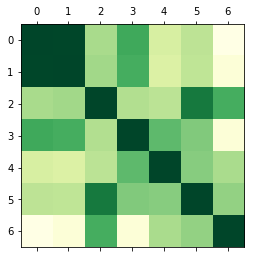

In [62]:
tmp = df_with_sentiment[['NumberOfHelpfulVotes', 'TotalNumberOfVotes', 'Score', 'WordsInSummary', 'WordsInText', 
         'SentimentOfSummary', 'SentimentOfText']]
plt.matshow(tmp.corr(), cmap=plt.cm.YlGn)
plt.show()

As we found out, the sentiment of the review title and review text has strong correlation with the score/rating given to the product, which makse sense. But we could not find any correlation between sentiment and helpfulness of the review.